(plots_intro)=
# Introduction to batteries-included plots

In this tutorial, we'll show how to interact with the {term}`aesthetics` mapping and {term}`faceting` powered by {class}`~arviz_plots.PlotCollection`. To keep the example concrete, we'll use {func}`~arviz_plots.plot_dist`, but the main concepts apply to other `plot_...` plotting functions in `arviz_plots`.


{func}`~arviz_plots.plot_dist` is a "batteries-included" function that plots 1D marginal distributions in the style of John K. Kruschke's __[_Doing Bayesian Data Analysis_](https://sites.google.com/site/doingbayesiandataanalysis/)__ book. In older versions of ArviZ it used to be called `plot_posterior`.

In [1]:
import numpy as np
import arviz_plots as azp
from arviz_base import load_arviz_data

In [2]:
azp.style.use("arviz-variat")

In [3]:
schools = load_arviz_data("centered_eight")

## Default behaviour

`plot_...` functions only have one required argument, the data to be plotted as `DataTree`.
These functions have a set of defaults regarding faceting, artist layout and labeling which should hopefully generate sensible figures independently of the data.

In `plot_dist`'s case, the default is to generate a grid of subplots, with as many subplots as variables and individual coordinate value combinations (after reducing the sampled dimensions). The `schools` dataset has 3 variables: `mu` and `tau` are scalar parameters of the model, and theta has an extra dimension `school` with 8 coordinate values.
Thus, a grid with $1+1+8=10$ subplots is generated:

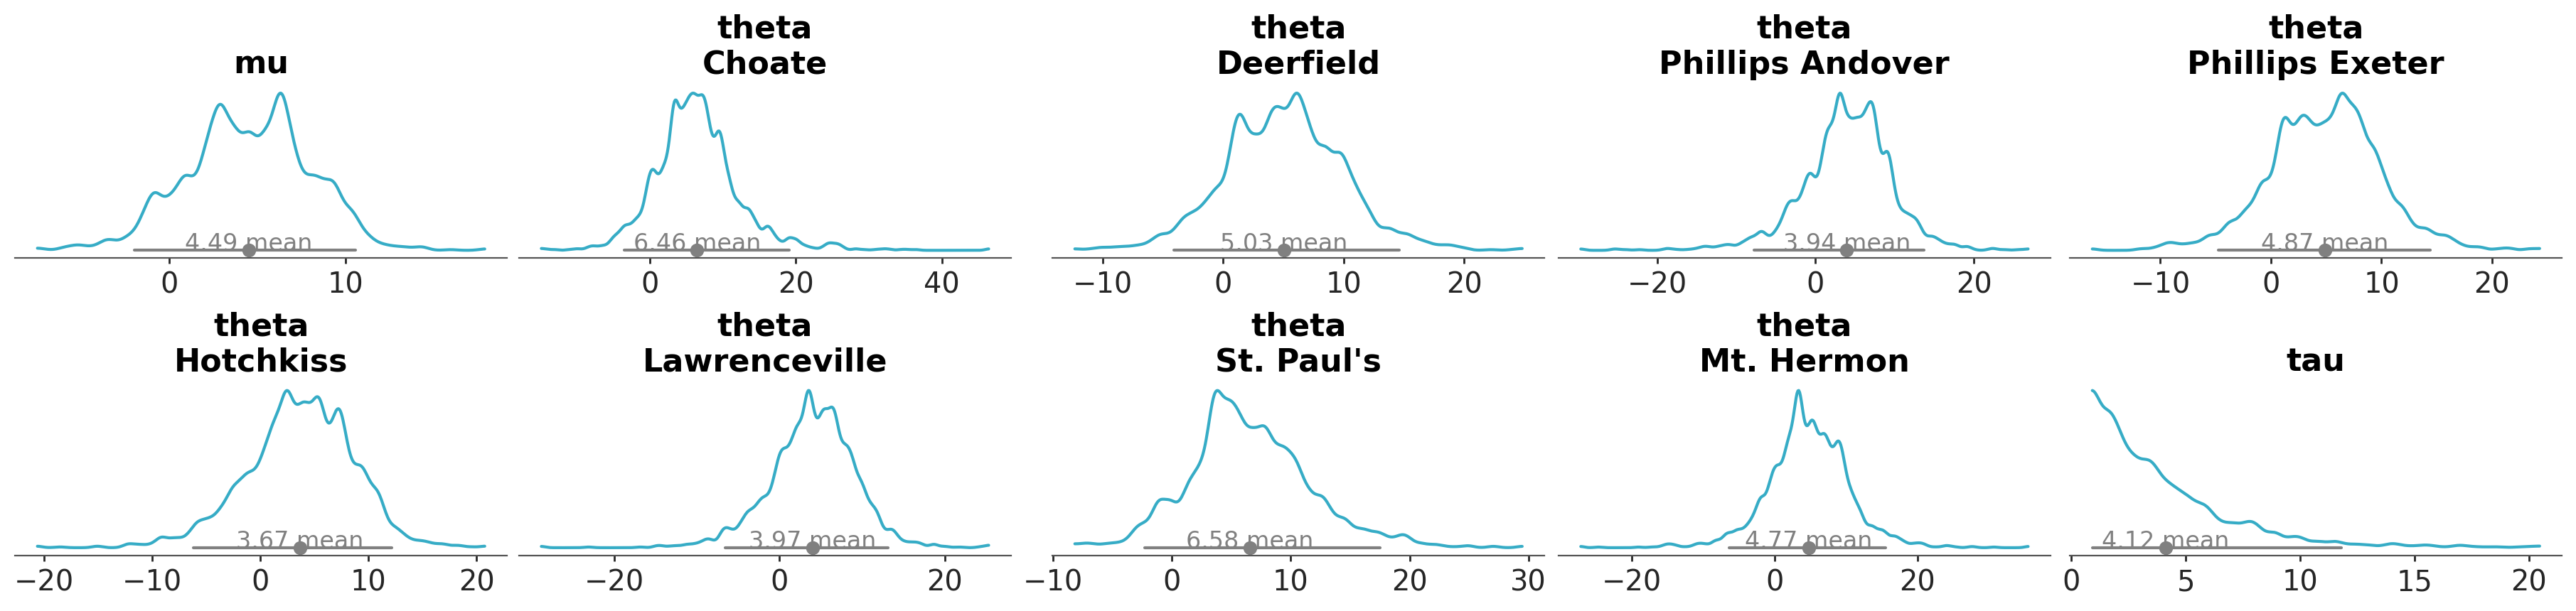

In [4]:
azp.plot_dist(schools);

As you can see, each subplot combines 3 statistical quantities derived from the data: 

* A probability density, here represented with a KDE
* A credible interval, by default an equal tail interval, here represented with a line 
* A point estimate, by default the mean, here represented with a filled circle.

Each `plot_...` will present different quantities using different representations, but the pattern remains the same.

## Customizing the plot

There are a handful of top level keyword arguments, related to data selection and general properties of the plot, and then a handful of arguments that take dictionaries that can provide finer control on the function behaviour.

In `plot_dist`'s case, the top level arguments are:

* Data selection related: `var_names`, `filter_vars`, `coords`, `group` and `sample_dims`. These arguments are used to select the data to be plotted and usually are available in all `plot_...` functions.
* Specific properties: `kind` to choose how to represent the probability density, `point_estimate` to choose which point estimate to use, `ci_kind` and `ci_prob` to control the credible interval. These arguments are specific to `plot_dist` but similar arguments are available in other `plot_...` functions. For example plots that shows densities will likely have a `kind` argument to choose the representation of the density.
* General properties. `plot_collection` in case you want to provide an existing {class}`~arviz_plots.PlotCollection` class, `backend` to choose the plotting backend and `labeller` to chose how to label each subplot. These arguments are available in all `plot_...` functions.
* Dictionary arguments: `plot_kwargs`, `stats_kwargs`, `pc_kwargs` and `aes_map`. These arguments are used to customize the behaviour of the plot in a more fine-grained way.


For the new user of `arviz_plots`, the arguments requiring more explanation are, most likely, the dictionary arguments. 
In the following sections we'll show how to use these arguments in detail.

## `plot_kwargs`

`plot_kwargs` is a dictionary that dispatches keyword arguments through to the backend plotting functions. Its keys should be graphical elements and its values should be dictionaries that are passed as is to the plotting functions. The docstrings of each `plot_...` function indicate which are the valid top level keys and where is each dictionary value dispatched to.

As you can see in its docstring, {func}`~arviz_plots.plot_dist` has 5 valid keys: kde, credible_interval, point_estimate, point_estimate_text and title.

### Modify properties of visual elements in all plots
We can use it to change the color of the KDE line:

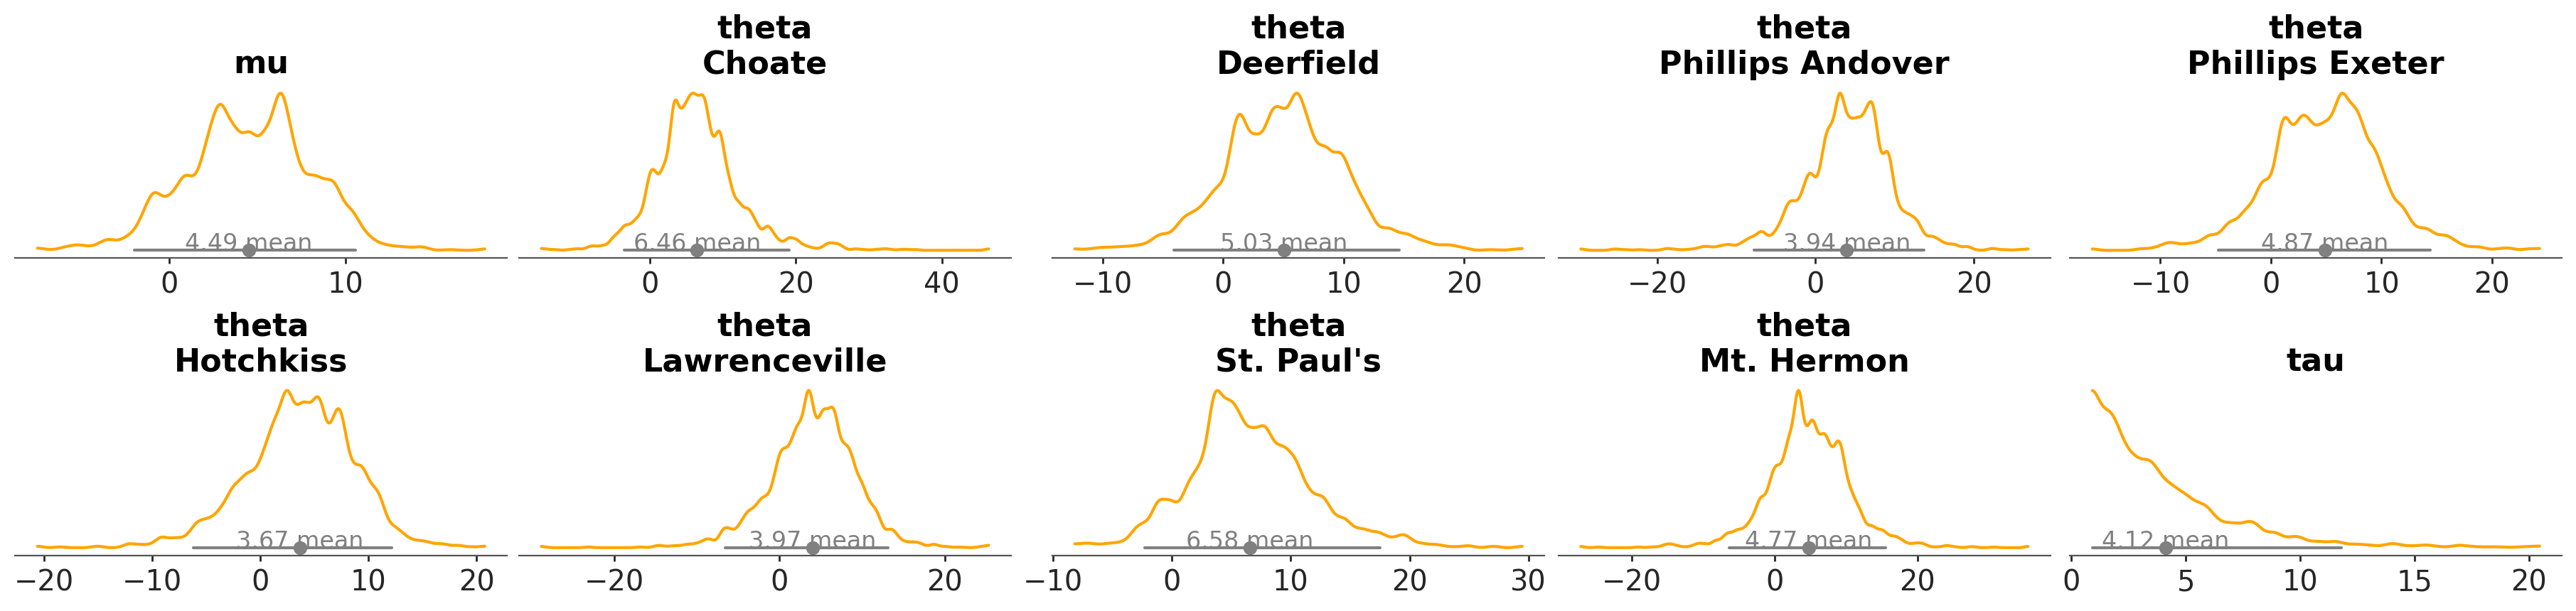

In [5]:
azp.plot_dist(schools, plot_kwargs={"kde": {"color": "orange"}});

Or to change the color and linestyle of the credible interval together with the fonts of the point estimate annotation and title:

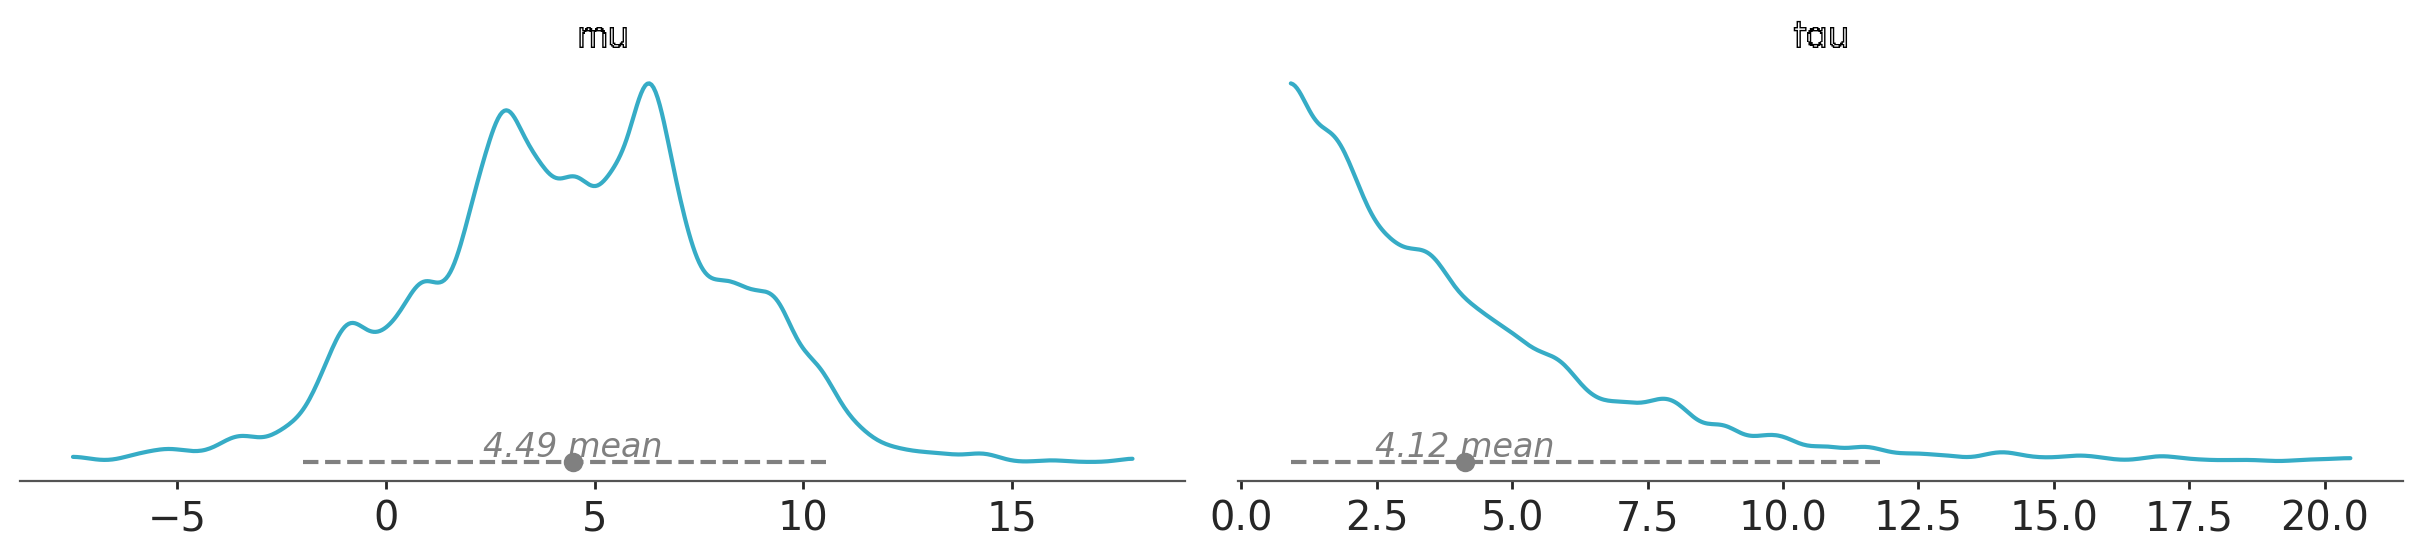

In [6]:
azp.plot_dist(
    schools,
    var_names=["mu", "tau"],
    plot_kwargs={
        "credible_interval": {"linestyle": "--"},
        "point_estimate_text": {"fontstyle": "italic"},
        #  font available at: https://gitlab.com/raphaelbastide/Terminal-Grotesque
        "title": {"fontfamily": "Terminal Grotesque Open"}
    }
);

### Remove visual elements from the plot
`plot_kwargs` can also be used to remove visual elements from the plot. For example, to keep only the marginal distribution representation:

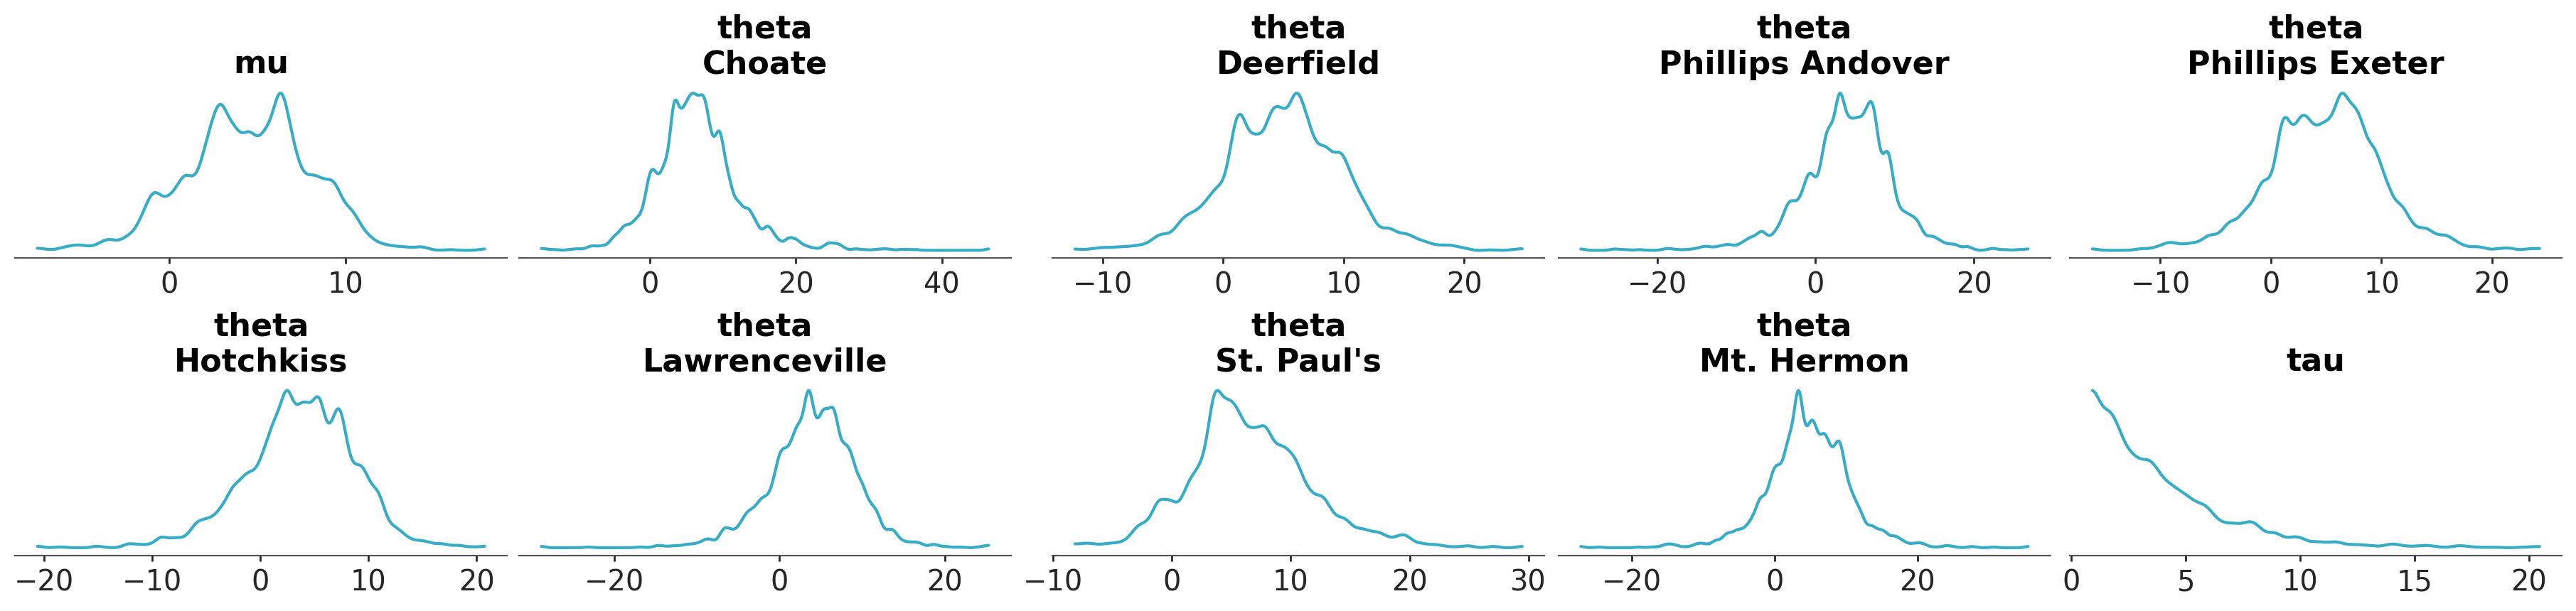

In [7]:
azp.plot_dist(
    schools, 
    plot_kwargs={
        "credible_interval": False,
        "point_estimate": False,
        "point_estimate_text": False,
    }
);

## `stats_kwargs`
`stats_kwargs` is a dictionary that dispatches keyword arguments through to the statistical computation function.

In `plot_dist` we can use it for example to control the kde computation and modify the bandwidth selection algorithm:

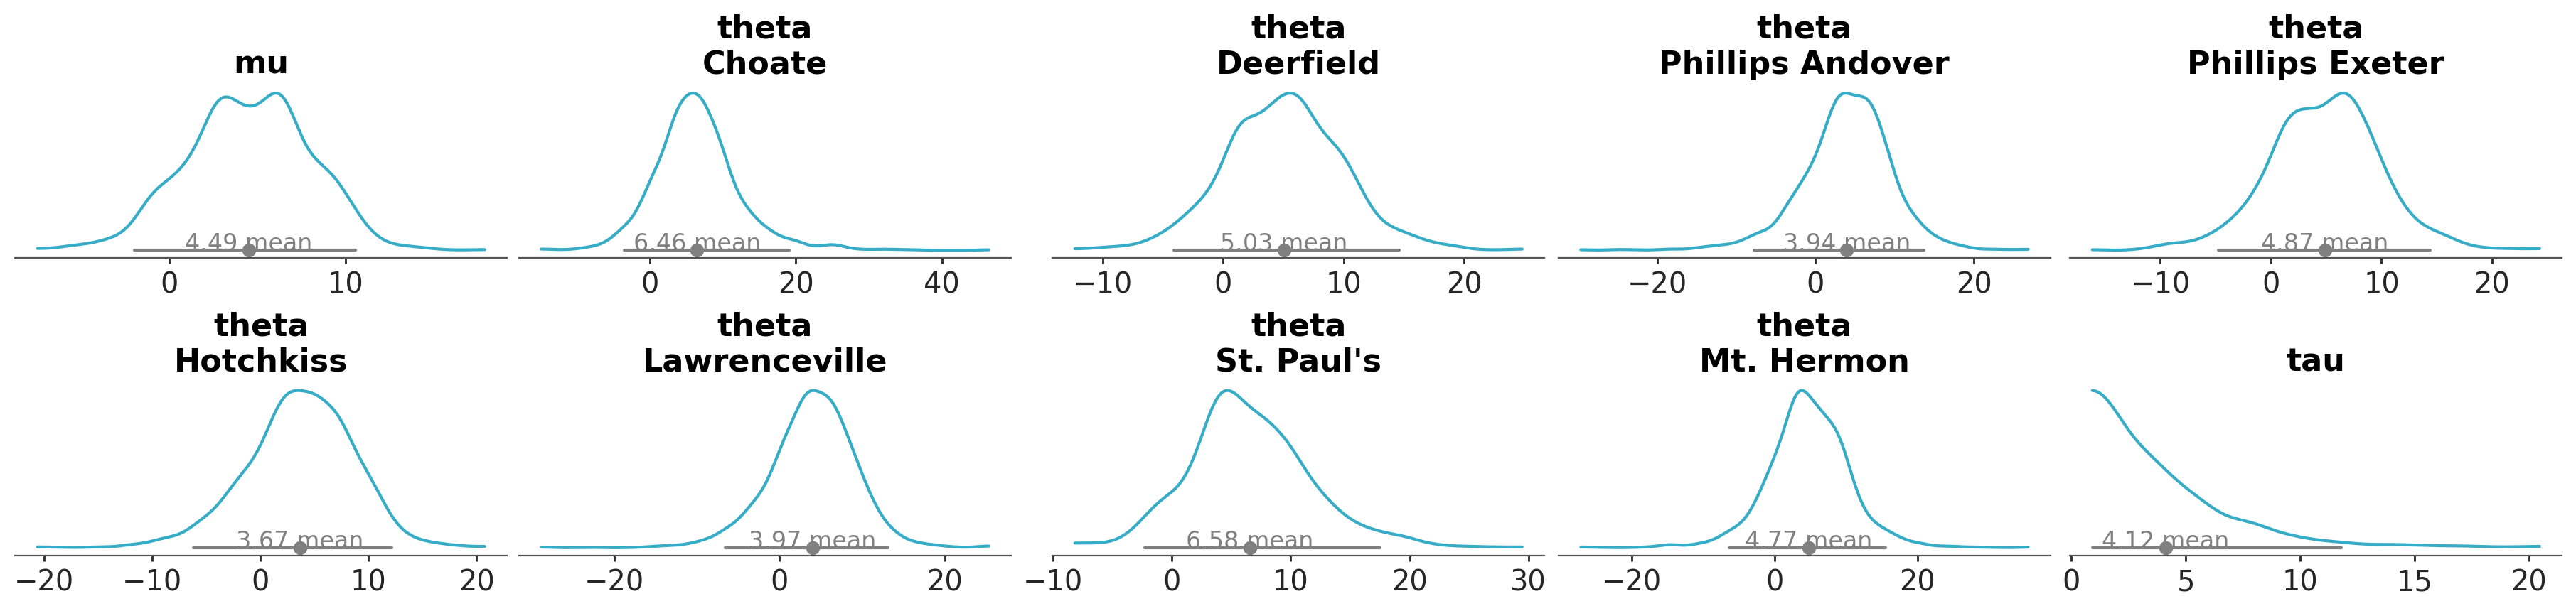

In [8]:
azp.plot_dist(schools, stats_kwargs={"density": {"bw": "scott"}});

## `pc_kwargs` and `aes_map`
`pc_kwargs` are passed to {meth}`arviz_plots.PlotCollection.wrap` to initialize the `PlotCollection` object that takes care of facetting and aesthetics mapping, and to generate and manage the chart. With it we can regulate from the figure size or sharing of axis limits, to modifying completely the layout and aesthetics of the generated plot.

Thus, each chart has a set of mappings between dataset properties and graphical properties. For example, we might encode the `school` information (dataset property) with the color (graphical property). And these mappings are shared between all subplots and between all graphical elements. `aes_map` regulates which mappings apply to which graphical elements; by default, mappings only apply to the density representation.

### Adding aesthetic mappings to a visualization

We can start by defining an aesthetics mapping:

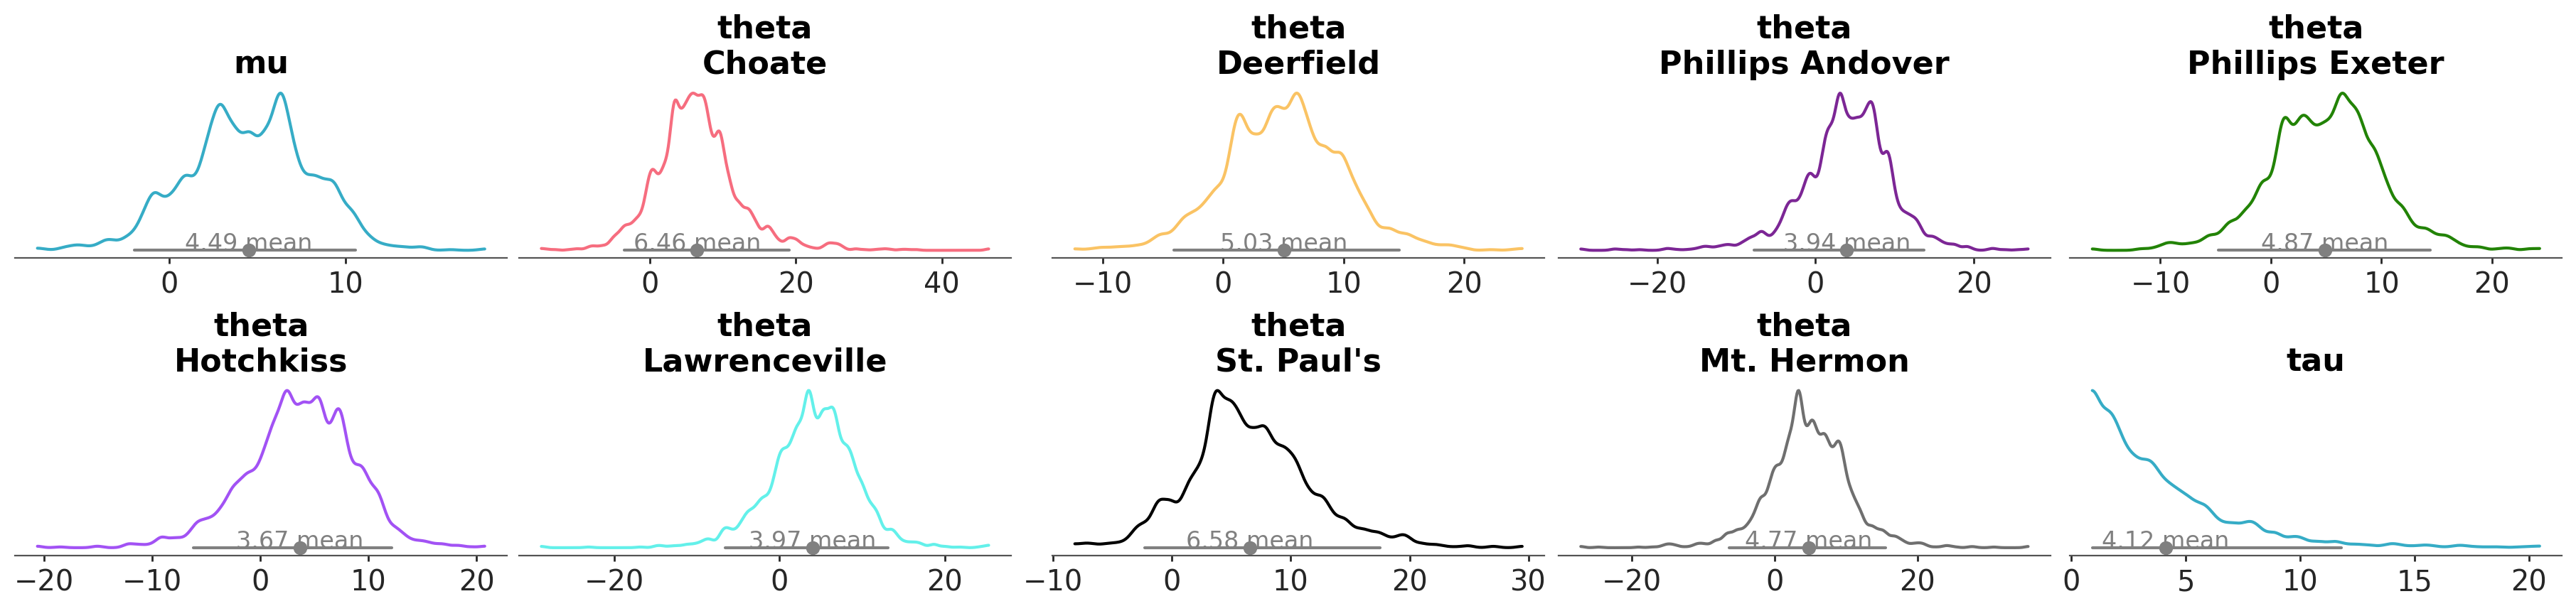

In [9]:
azp.plot_dist(
    schools,
    pc_kwargs={
        # encode the school information in the color property
        "aes": {"color": ["school"]},
    }
);

Note that `mu` and `tau` have a common color, which is different to any of the `theta` lines. As they don't have the `school` dimension, `PlotCollection` then takes
the first element in the aesthetic (in this case "C0", the first color of the matplotlib color cycle) as _neutral element_, then generates a mapping excluding that element.
The _neutral element_ is therefore reserved to be used when the mapping can't be applied _and only then_.

(plots_intro/ignore_aes_map)=
### Removing aesthetic mappings from a visualization

Similarly, we can also use `pc_kwargs` to remove aesthetic mappings from plots that define them by default. For example, {func}`plot_trace_dist` by default maps the linestyle to the chain dimension and the color to the variable and all non sample dims together.

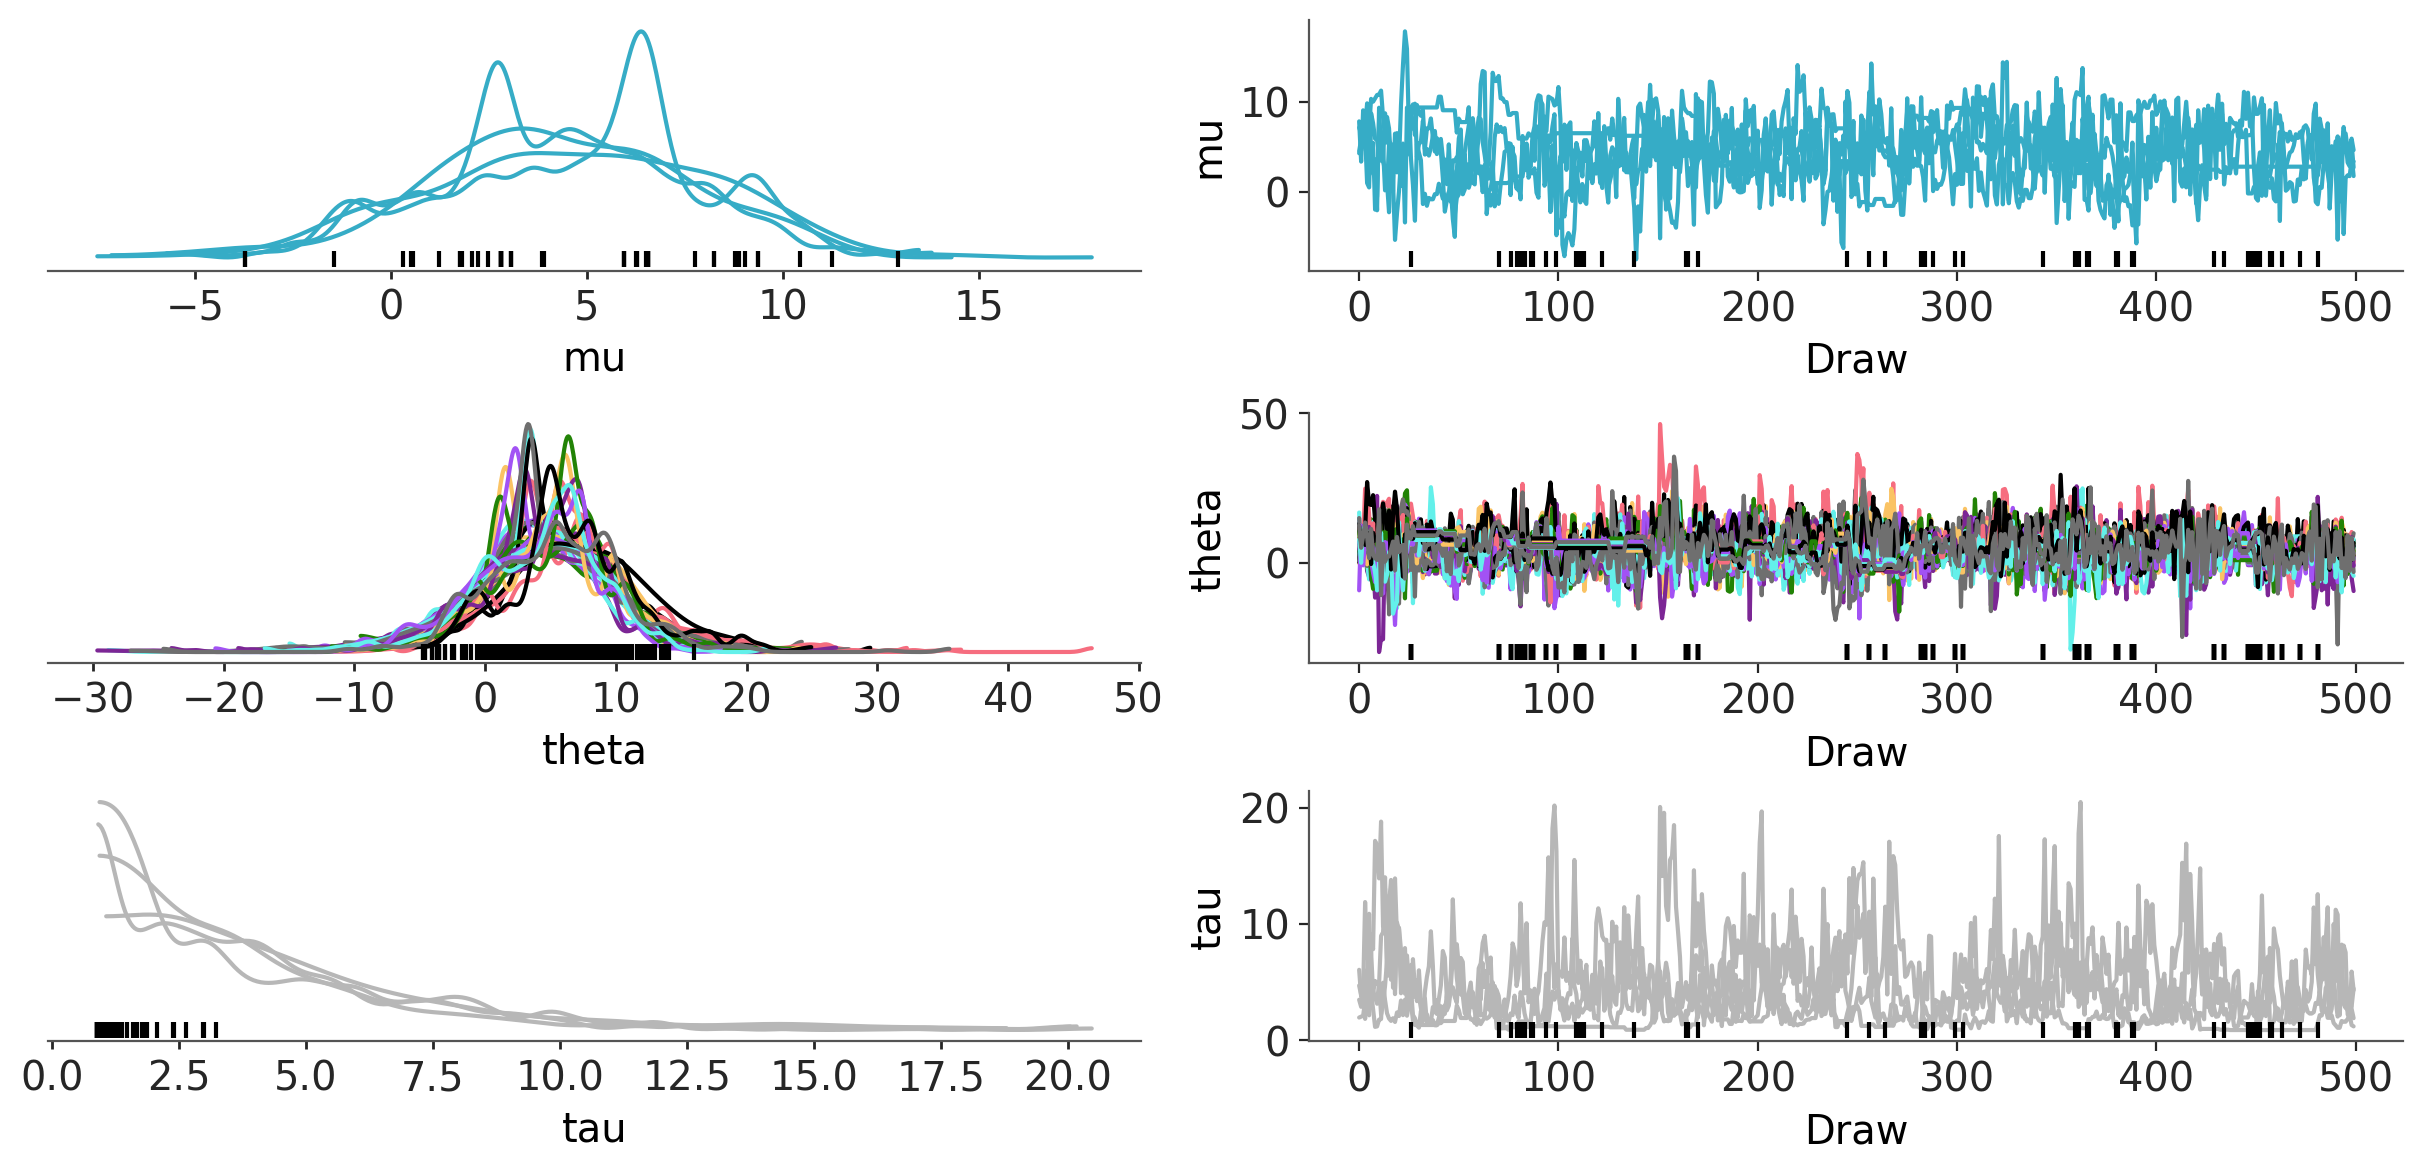

In [10]:
azp.plot_trace_dist(
    schools,
    pc_kwargs={"aes": {"linestyle": False}},
);

### Choosing the artists where aesthetic mappings are applied

We can configure which artists take the defined aesthetic mappings into account with `aes_map`:

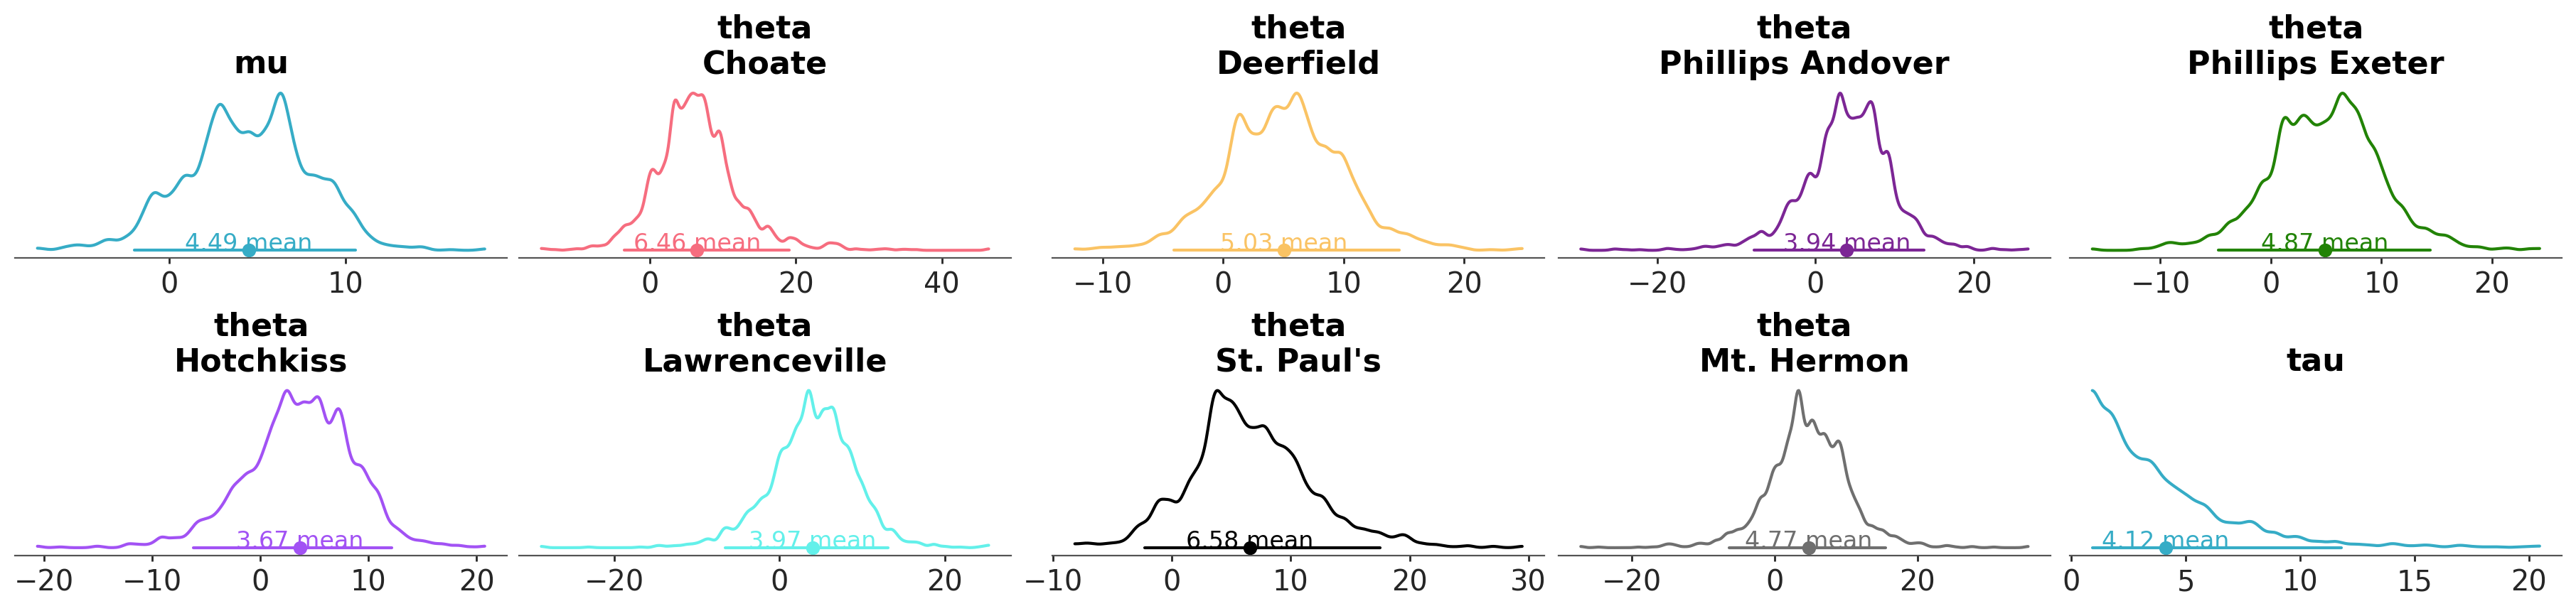

In [11]:
azp.plot_dist(
    schools,
    pc_kwargs={"aes": {"color": ["school"]}},
    # apply the color-school mapping to all graphical elements but the title
    aes_map={
        "kde": ["color"],
        "point_estimate": ["color"],
        "credible_interval": ["color"]
    }
);

We can have as many aesthetics mapping as desired, and map all of them, none or a subset of them to the different graphical elements:

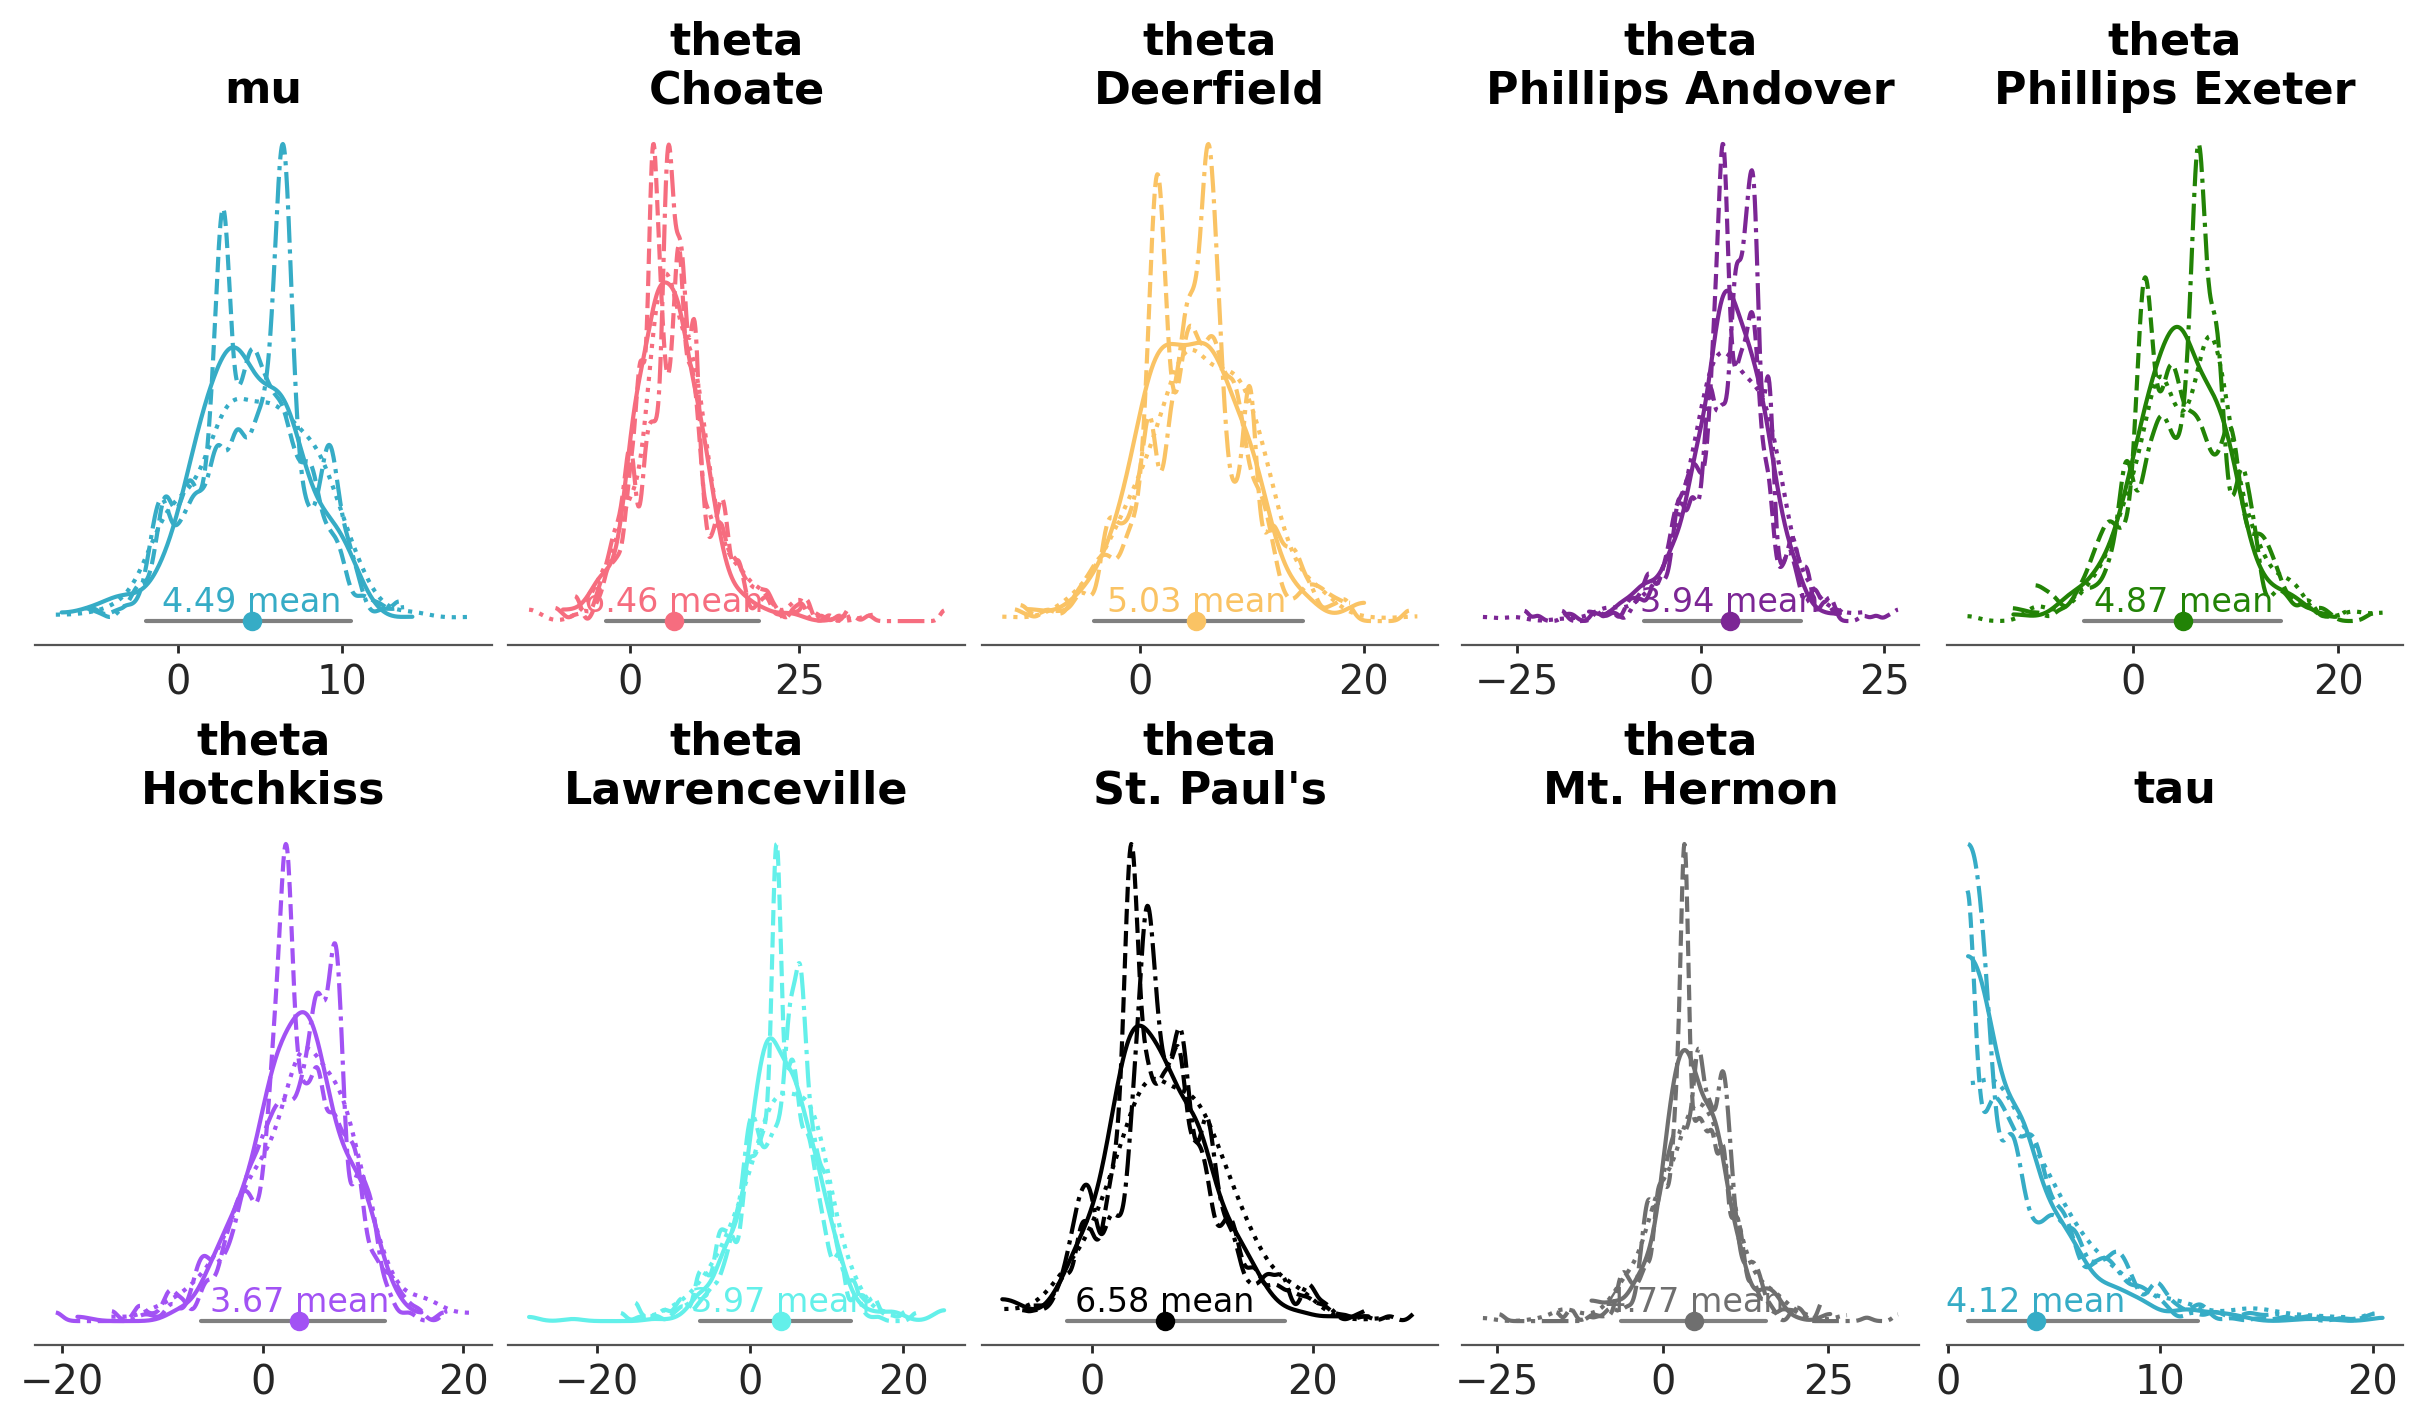

In [12]:
azp.plot_dist(
    schools, 
    pc_kwargs={
        "aes": {"color": ["school"], "linestyle": ["chain"]},
        "plot_grid_kws": {"figsize": (12, 7)}
    },
    aes_map={
        "kde": ["color", "linestyle"], # This is not necessary, as this mapping is the default
        "point_estimate": ["color"], # We extend the color-school mapping to the point estimate
    },
);

Note that now there is an aesthetic (linestyle) mapped to the `chain` dimension. Therefore, `PlotCollection` now loops over the `chain` dimension in order to enforce the aesthetic mapping, generating now 4 kde lines in each plot.

## Summary of the dictionary arguments

* `plot_kwargs`: Its keys should be graphical elements and its values should be dictionaries that are passed as is to the plotting functions. For example, if you want to change the color of the KDE, you can pass `plot_kwargs={'kde': {'color': 'red'}}`. Some other graphical elements for `plot_dist` are `point_estimate`, `point_estimate_text`, `title`, etc. For each plot you will find the graphical elements that can be modified in the documentation.
* `stats_kwargs`: Its keys should be a statistical element and its values should be dictionaries that are passed to modify the statistical functions. For example to change the bandwith method used to represent the densities, via a KDE, we can use `stats_kwargs={"density": {"bw": "scott"}}`. Some other statistical elements for `plot_dist` are `credible_interval` and `point_estimate`. For each plot you will find the statistical elements that can be modified in the documentation.
* `pc_kwargs`: These are passed to {meth}`arviz_plots.PlotCollection.wrap` to initialize the `PlotCollection` object that takes care of faceting and aesthetics mapping, and to generate and manage the chart. For instance to map the dataset property `school` to the graphical property `color` we use `pc_kwargs={"aes": {"color": ["school"]`. And to manually set the figure size we use `pc_kwargs={"plot_grid_kws": {"figsize": (12, 7)}}`.
* `aes_map`: Regulates which mappings apply to which graphical elements; by default, mappings only apply to the density representation. Thus if we have declared `pc_kwargs={"aes": {"color": ["school"]` this will only apply to `kde`, if we want to extend the mapping to the title we will need to pass `aes_map={"title": ["color"]}`. The valid keys for `aes_map` are the same as the ones for `plot_kwargs`, i.e. are graphical elements.

## Legends

Legends are not automatic, but can be generated by the `PlotCollection` class which is returned by all `plot_...` functions:

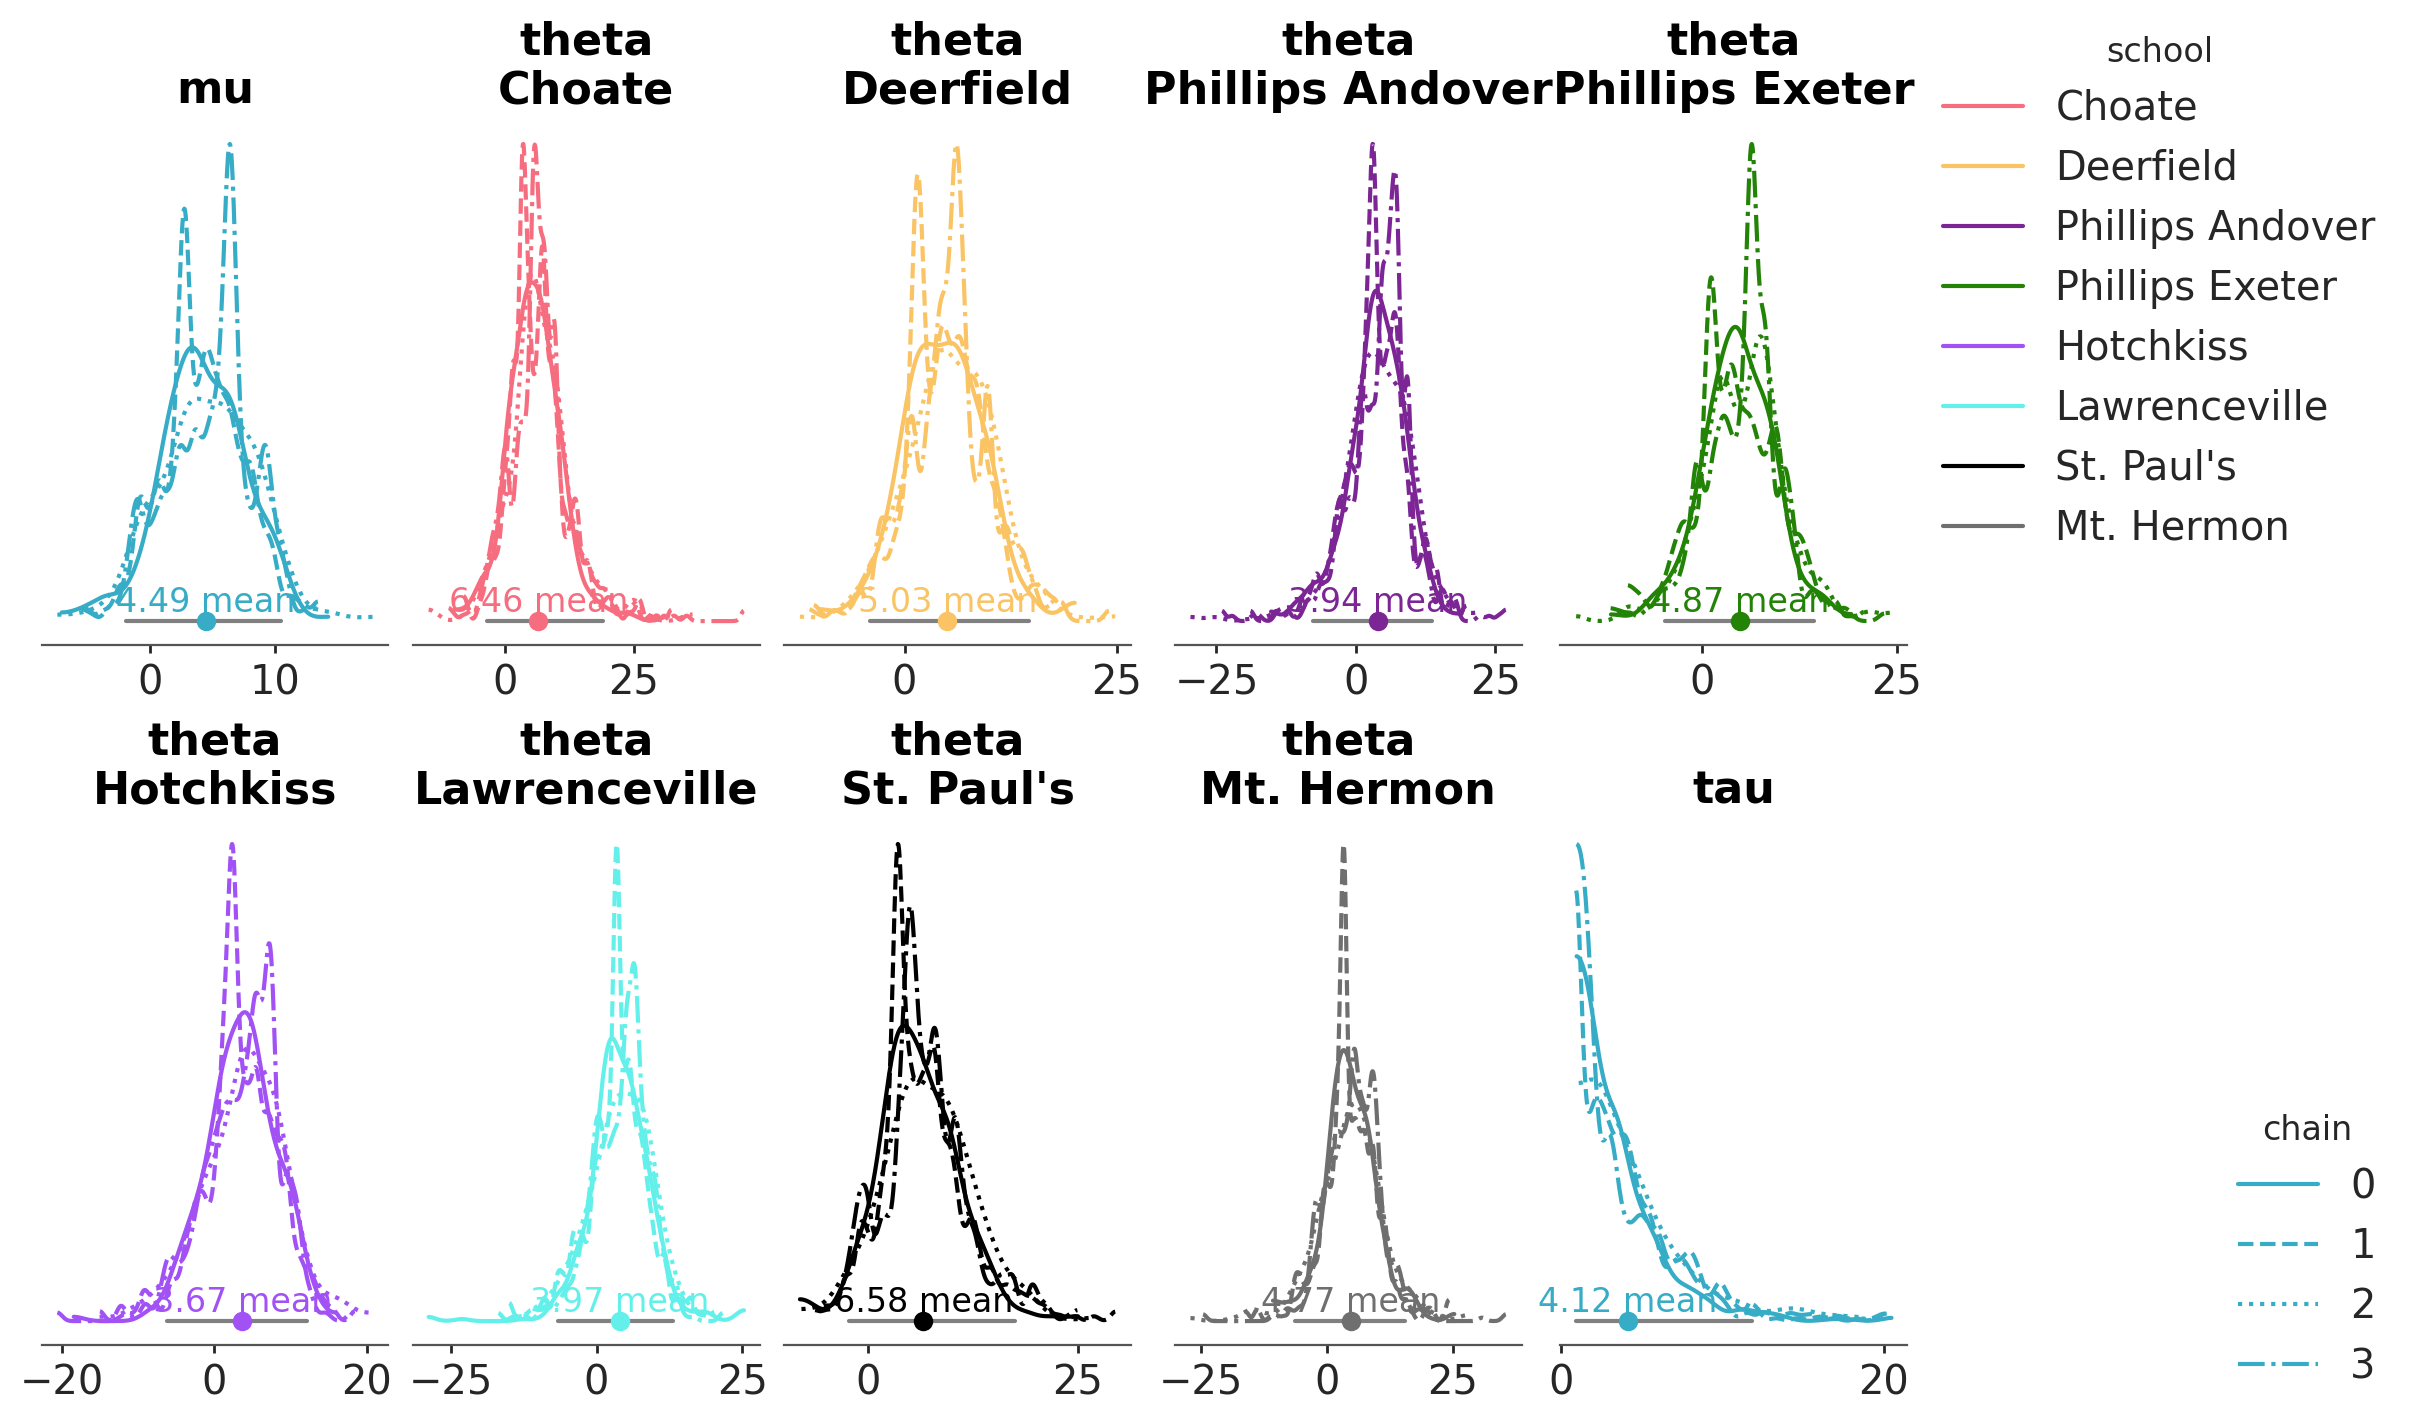

In [13]:
pc = azp.plot_dist(
    schools, 
    pc_kwargs={
        "aes": {"color": ["school"], "linestyle": ["chain"]},
        "plot_grid_kws": {"figsize": (12, 7)}
    },
    aes_map={"kde": ["color", "linestyle"], "point_estimate": ["color"]},
)
pc.add_legend("school", loc="outside right upper")
pc.add_legend("chain", loc="outside right lower");

## Advanced examples
So far we have called properties in which we encode aesthetics, and used color and linestyle as such properties. But `PlotCollection` only manages the mapping between a dataset property (in the form of a dimension) and a graphical property _with both key and values free to take anything_. The only limitation comes later when the mapped properties are passed down to the plotting function, these keys and values must be valid for the plotting function otherwise you'll get an error.

The functions used by `plot_dist` (and by other `plot_...` functions) aim to be somewhat general, so for example, `y` is a valid key for encoding information. But keep in mind that
if you want to generate plots significantly different from the default layout of `plot_dist` you'll need to follow the steps in {ref}`compose_own_plot` and use `PlotCollection` manually.

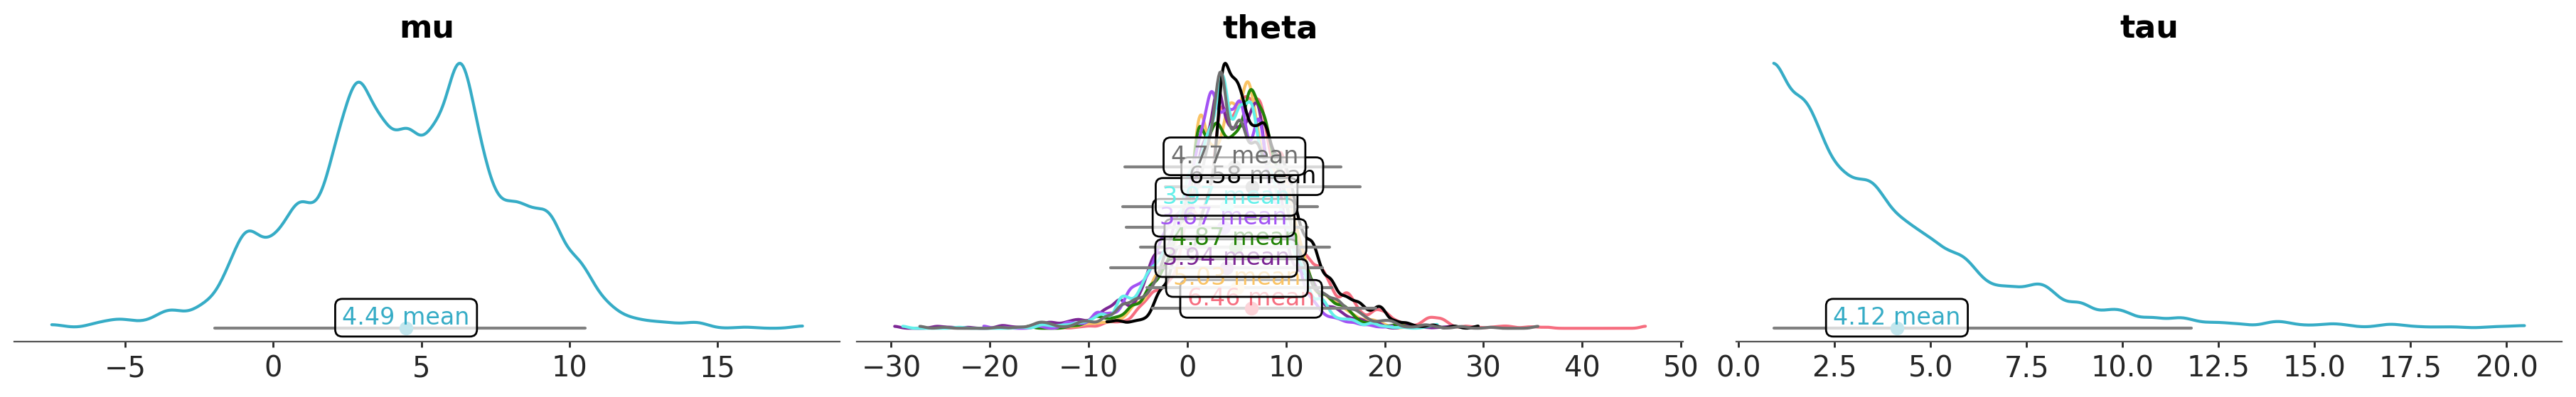

In [14]:
azp.plot_dist(
    schools, 
    pc_kwargs={
        # stop creating one subplot per variable *and* coordinate value,
        # generate only one per variable, in this case 3 subplots
        "cols": ["__variable__"],
        # encode the school informatin in both color and y properties
        "aes": {"color": ["school"], "y": ["school"]},
        "y": np.linspace(0, 0.06, 9),
    },
    aes_map={
        "kde": ["color"],
        "point_estimate": ["color", "y"],
        "credible_interval": ["y"]
    },
    plot_kwargs={"point_estimate_text": {"bbox": {"boxstyle": "round", "fc": (1, 1, 1, 0.7)}}},
);

We can have a range of variables with different shapes and dimensions, and as long as we are careful with the facetting and mapping arguments to not have them contradict each other,
the underlying `PlotCollection` used by `plot_dict` can combine all the different variables into a single plot, mapping the aesthetics provided only when relevant:

Here for example we have 4 variables: a two dimensional one, two with 3 dimensions (but different dimensions for their 3rd one) and one with 4 dimensions:

In [15]:
rugby = load_arviz_data("rugby_field")
rugby.posterior.ds[["atts_team", "atts", "intercept", "sd_att"]]

<xarray.Dataset> Size: 340kB
Dimensions:    (chain: 4, draw: 500, team: 6, field: 2)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * field      (field) <U4 32B 'home' 'away'
  * team       (team) <U8 192B 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
Data variables:
    atts_team  (chain, draw, team) float64 96kB ...
    atts       (chain, draw, field, team) float64 192kB ...
    intercept  (chain, draw, field) float64 32kB ...
    sd_att     (chain, draw) float64 16kB ...
Attributes:
    created_at:                 2024-02-23T20:21:03.016373
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4+7.g34d2a5d9
    sampling_time:              21.146891355514526
    tuning_steps:               1000

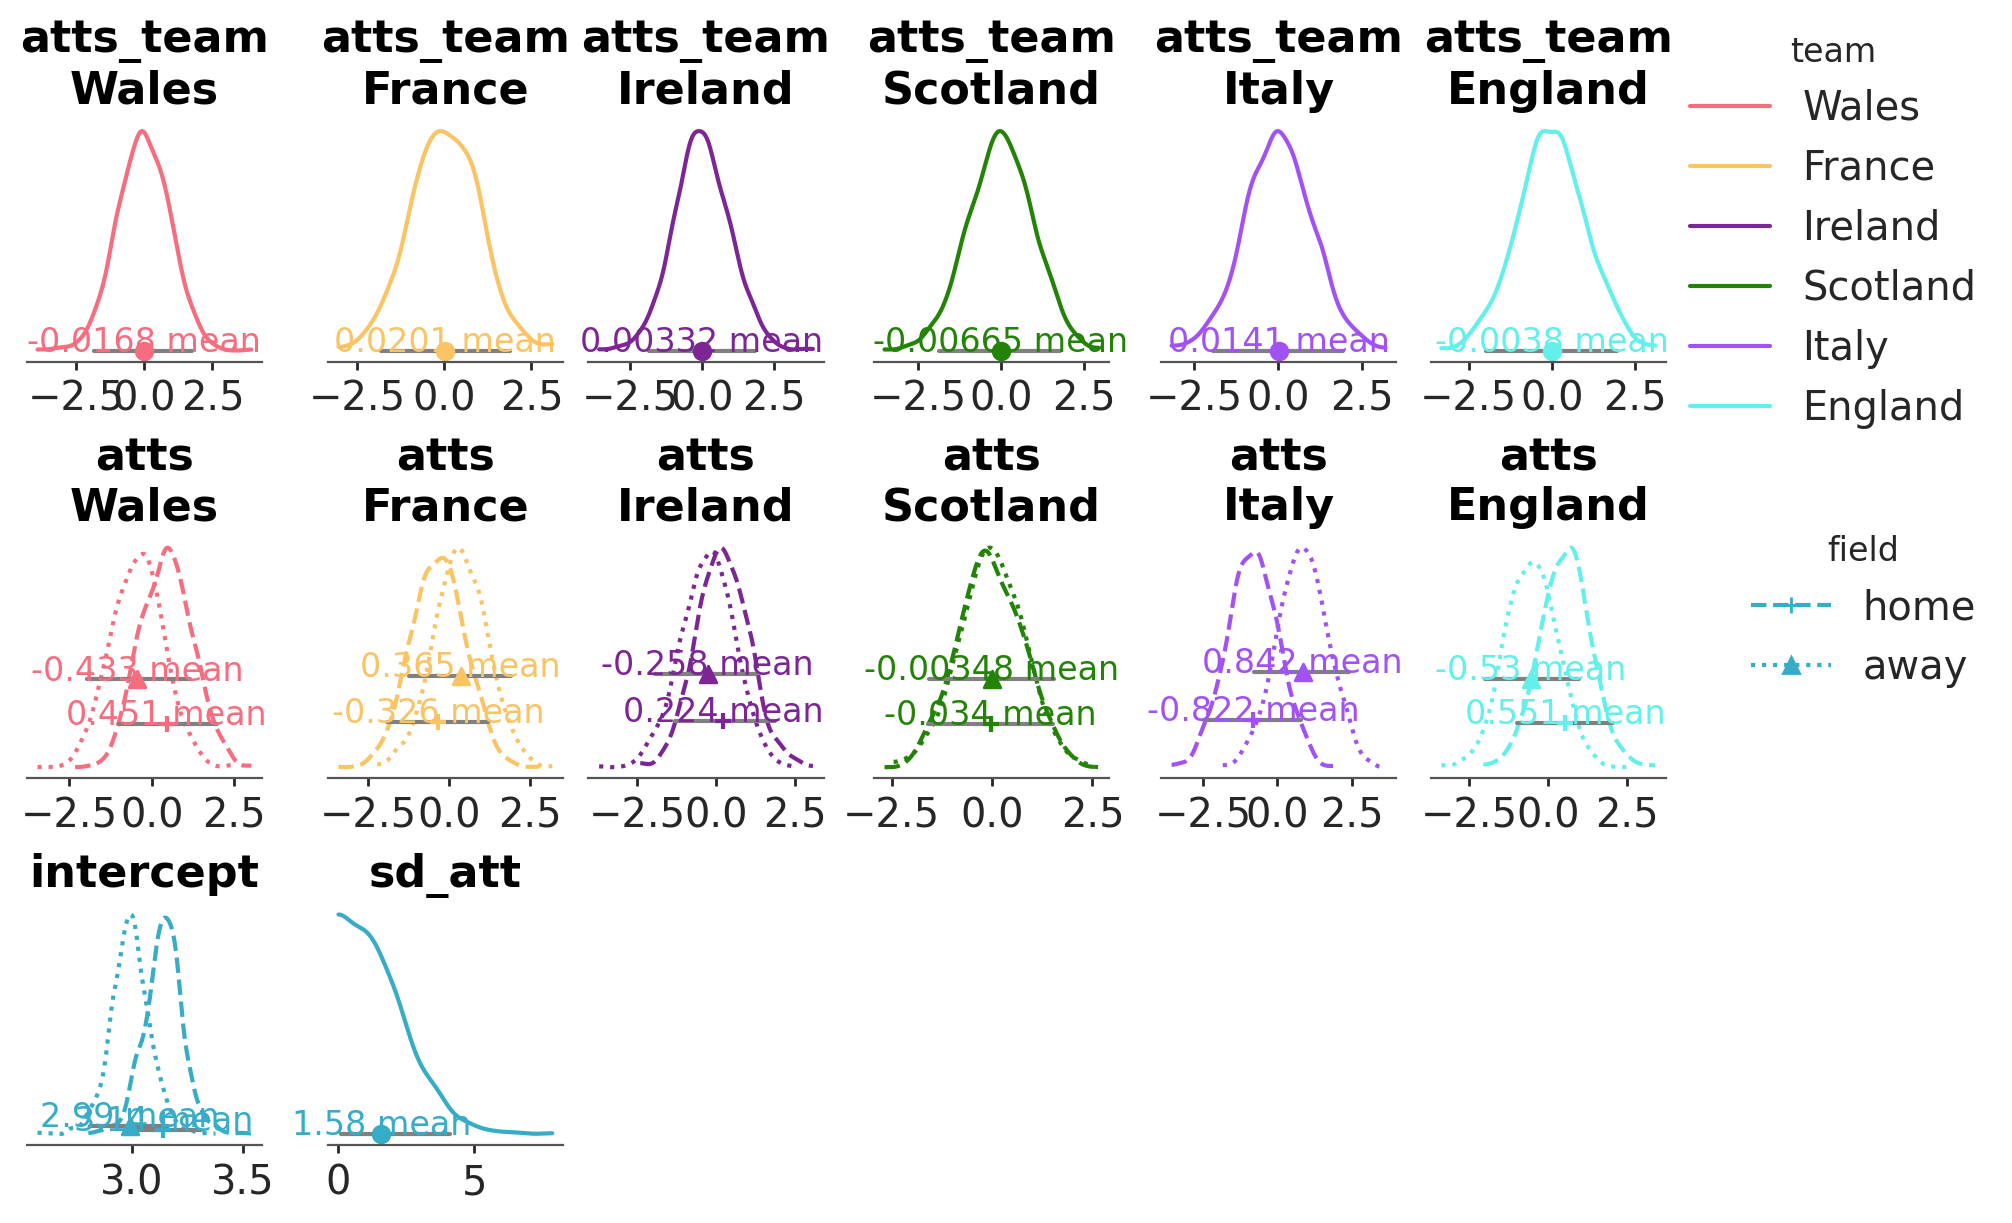

In [16]:
pc = azp.plot_dist(
    rugby,
    var_names=["atts_team", "atts", "intercept", "sd_att"],
    pc_kwargs={
        "cols": ["__variable__", "team"],
        "col_wrap": 6,
        "plot_grid_kws": {"figsize": (10, 6)},
        "aes": {
            "linestyle": ["field"],
            "color": ["team"],
            "marker": ["field"],
            "y": ["field"]
        },
        "y": [0, 0.1, 0.2]
    },
    aes_map={
        "kde": ["color", "linestyle"],
        "point_estimate": ["color", "marker", "y"],
        "point_estimate_text": ["color", "y"],
        "credible_interval": ["y"]
    },
)
pc.add_legend("team")
pc.add_legend("field", loc="outside right center");

:::{seealso}
* {ref}`use_plotcollection` covers handling of `PlotCollection` objects to further customize and inspect the plots generated with batteries-included functions.
* {ref}`compose_own_plot` shows how to create and fill visualizations from scratch using `PlotCollection` to allow you to generate your own specific plotting functions,
  or to generate domain specific batteries-included ones
:::